In [1]:
!pip install --upgrade yfinance

In [3]:
!pip install pandas
!pip install numpy
!pip install pandas-datareader
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install yfinance

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import minimize

# Define stock tickers
techassets = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'META', 'TSLA', 'NVDA']
bankingassets = ['BRK-B', 'JPM', 'V', 'BAC', 'AXP', 'GS', 'BLK', 'STT']
healthcareassets = ['LLY', 'JNJ', 'ABT', 'MDT', 'UNH', 'PFE', 'CVS', 'MRK']
all_assets = techassets + bankingassets + healthcareassets

# Define date range
start_date = '2014-01-01'
end_date = '2025-02-23'  # Set to current date

# Fetch stock data using yfinance
stock_data = {}
failed_downloads = []
for ticker in all_assets:
    try:
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
        print(f'Successfully downloaded data for {ticker}')
    except Exception as e:
        print(f'Failed to download data for {ticker}: {e}')
        failed_downloads.append(ticker)

# Remove failed tickers from the list
all_assets = [ticker for ticker in all_assets if ticker not in failed_downloads]

# Fetch S&P 500 data
try:
    sp500_data = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)
    print('Successfully downloaded data for S&P 500')
except Exception as e:
    print(f'Failed to download data for S&P 500: {e}')

# Check if 'Adj Close' column exists for each ticker and handle missing columns
for ticker in all_assets:
    if 'Adj Close' not in stock_data[ticker].columns:
        stock_data[ticker]['Adj Close'] = stock_data[ticker]['Close']

# Combine data into a single DataFrame
combined_data = pd.concat([stock_data[ticker][['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']] for ticker in all_assets], axis=1)
combined_data.columns = pd.MultiIndex.from_product([all_assets, ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']])

# Calculate daily returns and add them to the combined_data DataFrame
daily_returns = {}
for ticker in all_assets:
    daily_returns[(ticker, 'Daily Return')] = combined_data[(ticker, 'Close')].pct_change()
daily_returns_df = pd.DataFrame(daily_returns)

# Calculate moving averages and add them to the combined_data DataFrame
moving_averages_50 = {}
moving_averages_200 = {}
for ticker in all_assets:
    moving_averages_50[(ticker, '50 Day MA')] = combined_data[(ticker, 'Close')].rolling(window=50).mean()
    moving_averages_200[(ticker, '200 Day MA')] = combined_data[(ticker, 'Close')].rolling(window=200).mean()
moving_averages_50_df = pd.DataFrame(moving_averages_50)
moving_averages_200_df = pd.DataFrame(moving_averages_200)

# Calculate volatility (standard deviation of returns) and add to the combined_data DataFrame
volatility = {}
for ticker in all_assets:
    volatility[(ticker, 'Volatility')] = daily_returns_df[(ticker, 'Daily Return')].rolling(window=50).std()
volatility_df = pd.DataFrame(volatility)

# Concatenate additional metrics
combined_data = pd.concat([combined_data, daily_returns_df, moving_averages_50_df, moving_averages_200_df, volatility_df], axis=1)

# Drop any rows with NaN values due to rolling calculations
combined_data.dropna(inplace=True)

# Check shape of the data before normalization
print("Shape of combined_data.xs('Close', axis=1, level=1):", combined_data.xs('Close', axis=1, level=1).shape)
print("Columns of combined_data.xs('Close', axis=1, level=1):", combined_data.xs('Close', axis=1, level=1).columns)
print("Length of all_assets:", len(all_assets))

# Calculate expected returns and covariance matrix
returns = combined_data.xs('Daily Return', axis=1, level=1)
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the number of portfolios
num_portfolios = 10000

# Initialize empty lists to store portfolio returns, volatility, and weights
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Generate random weights for the portfolio
    weights = np.random.random(len(all_assets))
    weights /= np.sum(weights)
    
    # Calculate portfolio return and volatility
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    
    # Store the results
    results[0, i] = portfolio_volatility
    results[1, i] = portfolio_return
    results[2, i] = results[1, i] / results[0, i]  # Sharpe ratio
    
    # Store the weights
    weights_record.append(weights)

# Convert results to a DataFrame
results_df = pd.DataFrame(results.T, columns=['Volatility', 'Return', 'Sharpe Ratio'])

# Check for missing values
missing_values = combined_data.isnull().sum()
print(missing_values[missing_values > 0])

# Drop rows with any missing values
combined_data.dropna(inplace=True)

# Re-check for missing values
missing_values = combined_data.isnull().sum()
print(missing_values[missing_values > 0])

# Ensure DataFrame is not empty
if combined_data.empty:
    raise ValueError("DataFrame is empty after cleaning. Check data fetching and cleaning steps.")

# Normalize the data for machine learning
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_data.xs('Close', axis=1, level=1))

# Convert scaled data back to DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=combined_data.xs('Close', axis=1, level=1).columns, index=combined_data.index)

# Prepare the data for LSTM model
window_size = 60
X = []
y = []

for i in range(window_size, len(scaled_data_df)):
    X.append(scaled_data_df.iloc[i-window_size:i].values)
    y.append(scaled_data_df.iloc[i].values)

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, {y_test.shape}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AAPL
Successfully downloaded data for MSFT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for GOOG
Successfully downloaded data for AMZN
Successfully downloaded data for ORCL



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for META
Successfully downloaded data for TSLA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for NVDA
Successfully downloaded data for BRK-B
Successfully downloaded data for JPM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for V
Successfully downloaded data for BAC
Successfully downloaded data for AXP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GS
Successfully downloaded data for BLK
Successfully downloaded data for STT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for LLY
Successfully downloaded data for JNJ
Successfully downloaded data for ABT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for MDT
Successfully downloaded data for UNH


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for PFE
Successfully downloaded data for CVS
Successfully downloaded data for MRK



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for S&P 500
Shape of combined_data.xs('Close', axis=1, level=1): (2603, 24)
Columns of combined_data.xs('Close', axis=1, level=1): Index(['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'META', 'TSLA', 'NVDA', 'BRK-B',
       'JPM', 'V', 'BAC', 'AXP', 'GS', 'BLK', 'STT', 'LLY', 'JNJ', 'ABT',
       'MDT', 'UNH', 'PFE', 'CVS', 'MRK'],
      dtype='object')
Length of all_assets: 24
Series([], dtype: int64)
Series([], dtype: int64)
Training data shape: (2034, 60, 24), (2034, 24)
Testing data shape: (509, 60, 24), (509, 24)


In [14]:
print(combined_data.xs)

<bound method NDFrame.xs of                   AAPL                                                 \
                  High         Low        Open       Close     Volume   
Date                                                                    
2014-10-16   21.643937   21.132297   21.163305   21.320562  288618000   
2014-10-17   21.927441   21.442379   21.595207   21.632860  272718800   
2014-10-20   22.140075   21.754684   21.776832   22.095778  310069200   
2014-10-21   22.817833   22.430226   22.817833   22.696014  378495600   
2014-10-22   23.059256   22.724807   22.777964   22.811188  273052400   
...                ...         ...         ...         ...        ...   
2025-02-14  245.550003  240.990005  241.250000  244.600006   40896200   
2025-02-18  245.179993  241.839996  244.149994  244.470001   48822500   
2025-02-19  246.009995  243.160004  244.660004  244.869995   32204200   
2025-02-20  246.779999  244.289993  244.940002  245.830002   32316900   
2025-02-21  248.690002 

Training data shape: (2288, 60, 24), (2288, 24)
Testing data shape: (255, 60, 24), (255, 24)


C:\Users\lynch\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 0.0287 - val_loss: 0.0278
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0017 - val_loss: 0.0228
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0012 - val_loss: 0.0176
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 9.6565e-04 - val_loss: 0.0171
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 8.5439e-04 - val_loss: 0.0151
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 7.9400e-04 - val_loss: 0.0128
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 6.3850e-04 - val_loss: 0.0109
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 6.3261e-04 - val_loss: 0.0130
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 5.5856e-04 - val_loss: 0.0119
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 5.1274e-04 - val_loss: 0.0115
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 5.2552e-04 - val_loss: 0.0099
E

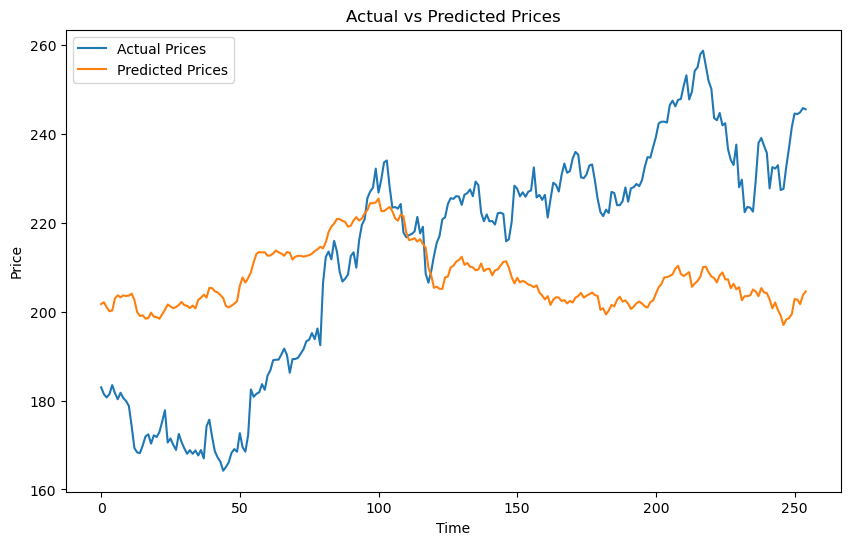

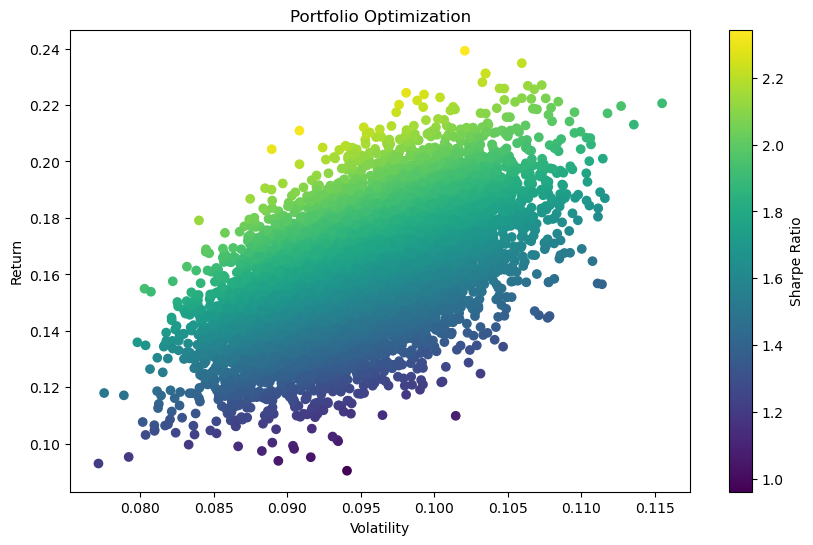

In [5]:
# Build Machine Learning Model Trial & Error with Multiple Models
# Tune Model feature selection + Hyperparameters + Cross Validation
# Visulaize & Evaluate Outputs
# Ask Nik best next steps to work toward finalization...
# Update LSTM Model to train/test on each ticker creating 24 LSTM Models
# Actual vs Predicted for each ticker over 60 day window
# Need to predict next 60 days for each ticker & highest prediction for each and how close the highest predicited price is to actual highest point over 60 days
# 1 model per ticker...

# Normalize the data for machine learning
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_data.xs('Close', axis=1, level=1))

# Convert scaled data back to DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=combined_data.xs('Close', axis=1, level=1).columns, index=combined_data.index)

# Prepare the data for LSTM model
window_size = 60
X = []
y = []

for i in range(window_size, len(scaled_data_df)):
    X.append(scaled_data_df.iloc[i-window_size:i].values)
    y.append(scaled_data_df.iloc[i].values)

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, {y_test.shape}')

# Step 1: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100))
model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 2: Train the LSTM Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Step 3: Evaluate the LSTM Model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Step 4: Make Predictions
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test)
     
# Step 5: Portfolio Optimization
# Calculate expected returns and covariance matrix for predicted prices
predicted_returns = pd.DataFrame(predicted_prices, columns=scaled_data_df.columns).pct_change().mean()
predicted_cov_matrix = pd.DataFrame(predicted_prices, columns=scaled_data_df.columns).pct_change().cov()


# Optimize the portfolio (example using random weights)
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(predicted_returns))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(predicted_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(predicted_cov_matrix * 252, weights)))
    
    results[0, i] = portfolio_volatility
    results[1, i] = portfolio_return
    results[2, i] = results[1, i] / results[0, i]  # Sharpe ratio
    
    weights_record.append(weights)

results_df = pd.DataFrame(results.T, columns=['Volatility', 'Return', 'Sharpe Ratio'])

# Step 6: Visualization
plt.figure(figsize=(10, 6))
plt.plot(actual_prices[:, 0], label='Actual Prices')
plt.plot(predicted_prices[:, 0], label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolio Optimization')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()